# Quando a Predição Falha

## Quando tudo o que você tem é um Martelo...
Entre 2015 e 2020, o Aprendizado de Máquina passou por um surto massivo. Sua utilidade comprovada nos campos de visão computacional e compreensão de linguagem natural, aliada à falta inicial de profissionais na área, proporcionou a oportunidade perfeita para uma indústria de ensino de aprendizado de máquina. Figuras como Andrew Ng e Sebastian Thrun conseguiram ensinar aprendizado de máquina ao mundo a preços acessíveis. Ao mesmo tempo, no lado do software, tornou-se cada vez mais fácil ajustar um modelo de aprendizado de máquina complexo (como você já viu pelas poucas linhas de código que levou para escrever um ML em capítulos anteriores). Tutoriais sobre como criar sistemas inteligentes brotaram por toda a internet. O custo de entrada em ML despencou.

![img](./data/img/when-prediction-fails/ml-in-5.png)
 
A construção de aprendizado de máquina tornou-se tão simples que nem era necessário saber programar muito bem (e eu sou a evidência viva disso), nem entender a matemática por trás dos algoritmos. Na verdade, você poderia criar maravilhas com apenas as seguintes 5 linhas de Python.
 
```python
X_train, y_train, X_test, y_test =  train_test_split(X, y)
 
## Instancia o modelo de aprendizado de máquina
model = MachineLearningModel()
 
## Treina o modelo
model.fit(X_train, y_train)
 
# Faz predição com dados não vistos
y_pred = model.predict(X_test)
 
# Avalia a qualidade das previsões
print("Performance", metric(y_test, y_pred))
```
 
Em grande parte, isso é algo incrível! Sou totalmente a favor de tornar conteúdo valioso acessível. No entanto, há também um lado sombrio nisso tudo. Essa nova onda de cientistas de dados foi treinada principalmente em modelagem preditiva, já que é isso que o aprendizado de máquina foca principalmente em resolver. Como resultado, sempre que esses cientistas de dados se deparavam com um problema de negócios, tentavam resolvê-lo, não surpreendentemente, com modelos preditivos. Quando eram realmente problemas de previsão, como vimos em capítulo anterior, o cientista de dados geralmente obtinha sucesso e todos ficavam felizes. No entanto, existe uma classe inteira de problemas que simplesmente não são resolvíveis com técnicas de previsão. E quando esses surgiam, os cientistas de dados geralmente fracassavam miseravelmente. São problemas formulados como "quanto posso aumentar Y alterando X".
 
Pela minha experiência, este outro tipo de problema é geralmente o que mais interessa à gestão. Eles frequentemente querem saber como aumentar as vendas, reduzir os custos ou atrair mais clientes. Sem dúvida, não ficam muito satisfeitos quando um cientista de dados apresenta uma resposta sobre como prever as vendas em vez de como aumentá-las. Infelizmente, quando tudo o que o cientista de dados conhece são modelos preditivos, isso tende a acontecer com frequência. Como um chefe meu uma vez me disse: "quando tudo o que você tem é um martelo, tudo começa a se parecer com um prego".
 
Como eu disse, sou totalmente a favor de reduzir o custo do conhecimento, mas o currículo atual de Cientista de Dados possui uma lacuna enorme. Acredito que meu trabalho aqui seja preencher essa lacuna. É equipar você com ferramentas para resolver essa outra classe de problemas, que são de natureza causal.

O que você está tentando fazer é estimar como algo que você pode controlar (publicidade, preço, atendimento ao cliente) afeta ou causa algo que você deseja mudar, mas não pode controlar diretamente (vendas, número de clientes, PNL). No entanto, antes de mostrar como resolver esses problemas, quero mostrar o que acontece quando você os trata como tarefas de previsão e tenta resolvê-los com as ferramentas tradicionais de aprendizado de máquina. A razão para isso é que frequentemente os cientistas de dados vêm até mim e dizem: "OK, embora abordar problemas causais com ferramentas de previsão não seja a melhor ideia, certamente ajuda em alguma coisa, não? Quero dizer, não pode prejudicar...". Bem, acontece que pode. E é melhor você entender isso antes de continuar martelando o seu próprio polegar.

![img](./data/img/when-prediction-fails/horse-meme.png)


In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

# helper functions for this notebook
from nb18 import ltv_with_coupons

## Quem Quer um Cupom?

Para tornar as coisas mais compreensíveis, vamos continuar com o exemplo que usamos em capítulo anterior, mas com um pequeno toque. Antes, estávamos tentando distinguir os clientes lucrativos dos não lucrativos. Moldamos isso como um problema de previsão: prever a lucratividade do cliente. Poderíamos então construir um modelo de aprendizado de máquina para essa tarefa e usá-lo para escolher com quem faríamos negócios: apenas os clientes que previmos serem lucrativos. Em outras palavras, nosso objetivo era separar os lucrativos dos não lucrativos, o que poderíamos fazer com um modelo preditivo.
 
Agora, você tem uma nova tarefa. Você suspeita que dar cupons para novos clientes aumenta o envolvimento deles com o seu negócio e os torna mais lucrativos a longo prazo. Ou seja, eles gastam mais e por um período mais longo. Sua nova missão é descobrir quanto deve ser o valor do cupom (incluindo zero). Observe que, com cupons, essencialmente você está dando dinheiro para as pessoas gastarem no seu negócio. Por esse motivo, eles entram como um custo na sua contabilidade. Note que se o valor do cupom for muito alto, você provavelmente perderá dinheiro, já que os clientes comprarão tudo o que precisam usando apenas os cupons. Isso é outra maneira de dizer que eles obterão seu produto de graça. Por outro lado, se o valor do cupom for muito baixo (ou zero), você nem está dando cupons. Isso pode ser uma resposta válida, mas também pode ser que alguns descontos antecipados, na forma de cupons, sejam mais lucrativos a longo prazo.
 
Por razões que você verá mais tarde, vamos usar uma função geradora de dados em vez de carregar um conjunto de dados estático. A função `ltv_with_coupons` gera dados de transações para nós. Como você pode ver, eles têm o mesmo formato do que vimos anteriormente, com uma linha por cliente, uma coluna para o custo de aquisição e colunas para as transações entre o dia 1 e o dia 30.

In [2]:
transactions, customer_features = ltv_with_coupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,5,0,2,2,...,0,3,0,4,0,0,0,0,0,0
1,1,-61,2,0,5,2,3,4,1,0,...,5,0,1,35,11,0,5,2,4,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


Quanto às outras partes dos dados, novamente, temos um id do cliente, a região em que o cliente mora, a renda do cliente e a idade do cliente. Além disso, agora temos uma variável chamada `coupons`, que nos diz quanto demos em cupons para aquele cliente.

In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,18,1025,5,24
1,1,40,1649,5,26
2,2,35,2034,15,33
3,3,29,1859,15,35
4,4,11,1243,5,26


Para processar esses dados em um único dataframe, vamos somar todas as colunas na primeira tabela (ou seja, somando `CACQ` com as transações). Isso nos dará o `net_value` como foi calculado no capítulo anterior. Depois disso, vamos unir os dados das características e atualizar o `net_value` para incluir o custo do cupom.

In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            # join net_value and features
            .merge(profitable, on="customer_id")
            # include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,15,33,-23
3,3,29,1859,15,35,-45
4,4,11,1243,5,26,-26


Este dataframe processado possui tudo o que precisamos. Ele possui nossa variável alvo `net_value`, possui nossas características do cliente `region`, `income` e `age`, e possui a alavanca ou tratamento que queremos otimizar: cupons. Apenas para começar a entender como os cupons podem aumentar o `net_value`, vamos analisar como eles foram distribuídos.

In [5]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

Podemos ver que a maioria dos cupons distribuídos tinha um valor de 5 BRL, seguido pelos cupons com valor de 10 BRL. Damos muito poucos cupons de 15 BRL ou nenhum cupom (valor zero). Isso indica que eles **NÃO** foram distribuídos aleatoriamente. Para verificar isso, vamos ver a correlação entre as outras variáveis e os cupons.

In [6]:
customer_features.corr()[["coupons"]]

,coupons
customer_id,0.002239
region,-0.004073
income,0.001236
coupons,1.000000
age,0.897308
net_value,-0.078369


Isso é interessante. Parece que quanto mais velha a pessoa, maior a probabilidade de ela receber um cupom. Isso é uma indicação de viés em nossos dados. Também podemos ver uma correlação negativa entre os cupons e o `net_value`: quanto mais cupons damos, menor é o `net_value`. Isso dificilmente é causal, já que já sabemos que os cupons não foram distribuídos aleatoriamente. Pode ser que, por exemplo, pessoas mais velhas gastem menos em nossos produtos e também recebam valores de cupons mais altos, confundindo a relação entre os cupons e o `net_value` a ponto de torná-la negativa.

O ponto é que sabemos que há viés. No entanto, como já há muito conteúdo neste capítulo, vou ignorá-lo por enquanto (na verdade, vou contornar o problema com um artifício que você verá em breve). Apenas tenha em mente que é algo que teremos que abordar em algum momento no futuro.

Neste ponto da análise, **se isso fosse um problema de previsão**, provavelmente dividiríamos o conjunto de dados em um conjunto de treinamento e um conjunto de teste para construir e avaliar algumas políticas, respectivamente. Mas este NÃO é um problema de previsão. O objetivo final aqui não é obter uma boa previsão sobre a lucratividade do cliente. Em vez disso, é descobrir a estratégia ideal de cupons. Para avaliar essa otimização, precisaríamos saber como as coisas teriam se desdobrado se tivéssemos dado cupons diferentes dos que foram dados. Esta é a espécie de pergunta "e se" contrafactual que temos estudado sob causalidade. A validação cruzada não nos ajudará aqui porque simplesmente não podemos observar contrafactuais. Só podemos ver o que aconteceu para os cupons que foram realmente dados, mas não podemos saber o que teria acontecido se os clientes recebessem um valor de cupom diferente. A menos que tenhamos dados simulados!

Se nossos dados são simulados, podemos gerar exatamente os mesmos dados, apenas alterando os parâmetros de valor do cupom. Isso nos permitirá ver como `net_value` muda sob diferentes estratégias de cupons. Em seguida, poderemos calcular o efeito do tratamento entre diferentes estratégias $NetValue_{t=a} - NetValue_{t=b}$. Com o poder dos dados simulados, entender este capítulo será muito mais fácil. Ah sim, e isso também tornará o problema de viés irrelevante, porque observaremos diretamente o efeito causal.

No entanto, lembre-se sempre de que este é um artifício pedagógico. No mundo real, você não tem dados simulados e certamente não pode ver o que teria acontecido sob diferentes estratégias de tratamento. Os efeitos causais individuais permanecem ocultos, como sempre foram. Isso coloca um problema interessante. Como podemos avaliar nossas estratégias para identificar o efeito causal se nunca podemos ver o efeito causal real? A resposta real é muito complexa e tão importante que merece seu próprio capítulo. Fique tranquilo que abordaremos isso. Por enquanto, aproveite a simplicidade dos dados simulados. E falando em simplicidade...


## Política Simples

Como sempre, a primeira coisa que devemos fazer sempre que nos deparamos com um novo problema de dados é nos perguntarmos "qual é a coisa mais simples que posso fazer que já trará valor?". Para este caso específico, a coisa mais simples é analisar os dados que temos e estimar o `net_value` para cada valor de cupom. Em seguida, verifique qual valor de cupom está gerando o maior `net_value` e dê apenas esse valor de cupom para cada cliente.

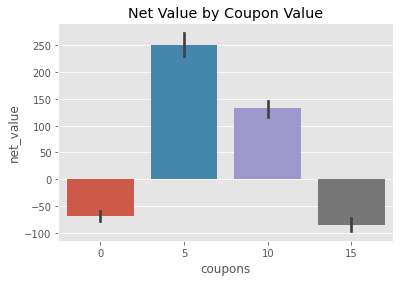

In [7]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value");

Ao fazer essa análise, podemos ver que, em média, perdemos dinheiro quando o valor do cupom é 0 ou 15, e ganhamos dinheiro para cupons de 5 e 10 BRL. O maior `net_income` médio ocorre quando temos cupons de 5 BRL, gerando cerca de 250 BRL em `net_value` por cliente. Naturalmente, então, a coisa mais simples que podemos tentar é dar a todos 5 BRL em cupons e ver como isso se desenrolaria. Isso desconsidera completamente a possibilidade de viés, mas ei, estamos falando de simplicidade aqui!

Para avaliar essa política, a função `ltv_with_coupons` aceita como argumento um array de 10000 elementos que contém o valor desejado do cupom para cada um dos 10000 clientes em nosso banco de dados. Para criar esse array, vamos gerar um array de uns com `np.ones` do tamanho do nosso array `coupons` (10000) e multiplicá-lo por 5. Em seguida, passaremos este array para o `ltv_with_coupons`. Isso gerará um novo conjunto de dados exatamente como o que tínhamos anteriormente, mas com cada valor de cupom definido como 5. Em seguida, processamos esses dados para obter o valor líquido sob essa nova política proposta.

In [8]:
simple_policy = 5 * np.ones(customer_features["coupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)
customer_features_simple_policy = process_data(transactions_simple_policy, customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,5,33,63
3,3,29,1859,5,35,63
4,4,11,1243,5,26,-26


Apenas como uma verificação de sanidade, vamos ver se as características realmente não mudaram, considerando os primeiros clientes. Pegue o terceiro cliente, por exemplo (`customer_id` 2). Para este cliente, a região é 35, a renda é 2034 e a idade é 33. Se subirmos um pouco, podemos ver que isso corresponde ao que tínhamos antes, então estamos bem aqui. Além disso, podemos verificar que todos os cupons são realmente de 5 BRL. Finalmente, o `net_value` muda como esperado. Uma razão para isso é que o custo associado aos cupons mudará. Por exemplo, aquele cliente tinha 15 BRL em cupons, mas agora são 5. Isso diminuiria o custo de 15 para 5 unidades. Mas observe que o `net_value` vai de -23 para 63, um aumento de 86 BRL no `net_value`. Isso é muito maior do que a diferença de custo de 10. Aqui, dar menos nos cupons tornou esse cliente específico muito mais lucrativo do que antes. Finalmente, para avaliar a política, podemos simplesmente calcular a média do `net_value`.

In [9]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

252.9268

Como podemos ver, esta política simples nos diz que podemos obter, em média, 253 BRL para cada cliente se dermos a todos um cupom de 5 BRL. Isso é incrível! Mas podemos fazer melhor? E se usarmos nossa reluzente ferramenta de aprendizado de máquina neste problema? Vamos tentar isso em seguida.


## Política com Modelo

Para usar aprendizado de máquina, vamos adaptar o que fizemos no capítulo anterior. A ideia é construir um modelo de aprendizado de máquina que prevê `net_value`, assim como antes, pegar essas previsões e agrupá-las em um número definido de faixas. Em seguida, particionaremos os dados nessas faixas. Essencialmente, estamos dividindo os clientes por seu `net_value` previsto. Os clientes que acreditamos que gerarão aproximadamente o mesmo `net_value` acabarão no mesmo bin ou grupo. Finalmente, para cada grupo, veremos qual valor de cupom gera o máximo `net_value`. Estamos fazendo a mesma coisa que na política simples, mas agora dentro dos grupos definidos por uma faixa de previsão.

![img](./data/img/when-prediction-fails/partitions.png)

A intuição por trás disso é a seguinte: sabemos que, em média, os cupons de 5 BRL se saíram melhor. No entanto, é possível que, para algum grupo de clientes, outro valor seja ainda melhor do que 5 BRL. Talvez 5 BRL seja a estratégia ótima para a maioria dos clientes, mas não para todos eles.

![img](./data/img/when-prediction-fails/personalise.png)

Se pudermos identificar aqueles em que o valor ótimo é diferente, podemos criar uma estratégia de cupons melhor do que a simples que fizemos acima.

Isso é o que chamamos de problema de personalização. Podemos aproveitar a personalização quando temos mais de uma estratégia para escolher e pelo menos uma delas não é a melhor estratégia geral, mas é a melhor em um subconjunto da população-alvo. Essa definição é um pouco complicada, mas a intuição é simples. Se você tem apenas uma estratégia, você não está personalizando. Você está fazendo a mesma coisa para todos os clientes. Se você tem mais de uma estratégia, mas uma delas é melhor para cada cliente, por que personalizar? Você poderia simplesmente fazer a melhor coisa. Você só fará personalização se tiver uma estratégia que funcione melhor em um subconjunto da população e outra estratégia que funcione melhor em outro subconjunto da população.

Mas voltando ao exemplo. A primeira coisa que precisamos é uma função que ajuste nosso modelo preditivo e também divida as previsões em faixas de previsão. Esta função retornará outra função, uma função de previsão que receberá um dataframe e adicionará colunas tanto para as previsões quanto para as faixas.

In [10]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])
        
        # discretize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False) 
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))
    
    return predict

Para avaliar a qualidade de nossas previsões, dividiremos o conjunto de dados em um conjunto de treinamento e um conjunto de teste. Observe que aqui estamos avaliando a qualidade da previsão, NÃO da política. Isso é apenas para ver se nosso modelo é bom em fazer o que é suposto fazer.

In [11]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

Agora, vamos treinar nosso modelo e criar 10 faixas com suas previsões.

In [12]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(1)
model = model_bands(train, features, target, model_params, n_bands=10)

Depois de treinar nosso modelo, podemos usá-lo para fazer previsões, passando um dataframe. O resultado também será um dataframe com 2 novas colunas: `predictions` e `pred_bands`.

In [13]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,30,567,5,27,-129,-16.296297,2
5910,5910,32,647,5,25,-55,-16.296297,2
1950,1950,31,2953,15,33,-142,102.237797,7
2119,2119,1,2860,5,27,-23,94.291197,7
5947,5947,49,589,5,26,-91,-3.525593,3


Para ver o poder preditivo de nosso modelo, podemos observar o $R^2$ tanto para os conjuntos de treinamento quanto para os conjuntos de teste.

In [14]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.5382953634651921
Test Score:,  0.504563847410434


Lembre-se de que esse desempenho é apenas o desempenho preditivo. O que realmente queremos saber é se esse modelo pode nos fazer ganhar dinheiro. Vamos criar uma política! A ideia aqui é muito semelhante ao que vimos no capítulo anterior. Agruparemos os clientes por faixa de modelo. Em seguida, para cada tipo de cliente (onde o tipo é definido pelas faixas), veremos qual decisão - valor do cupom no nosso caso - é a melhor. Para fazer isso, podemos agrupar nossos dados por faixa de previsão e valor do cupom e plotar o `net_value`.

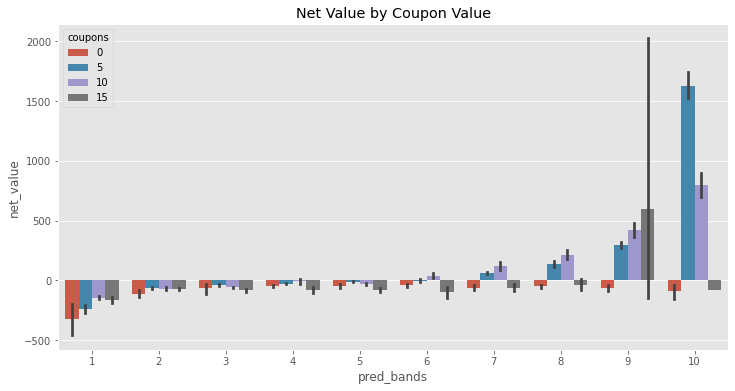

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value");

Este gráfico é muito interessante. Observe como a decisão ótima muda em diferentes faixas de previsão. Por exemplo, em faixas como 1, 7 e 8, a melhor coisa a fazer é dar 10 BRL em cupons. Para faixas como 3, 5 e 10, a melhor coisa é 5 BRL em cupons. Isso significa que esta política é muito parecida com a simples, exceto pela última faixa. Isso é uma evidência de que a personalização pode ser possível, já que a decisão ótima muda entre subpopulações.

Podemos codificar essa política com algumas declarações `if ... then ...`, mas vou mostrar uma abordagem mais geral que aproveita as operações de dataframe.

![img](./data/img/when-prediction-fails/pandas-magic.png)

Primeiro, agruparemos nossos clientes por faixa e valor do cupom e pegaremos a média do `net_value` para cada grupo, assim como o gráfico acima.

In [16]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "coupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-324.538462
1,1,5,-237.683871
2,1,10,-142.203390
3,1,15,-160.413223
4,2,0,-108.980769
5,2,5,-63.718650
6,2,10,-68.327146


Em seguida, agruparemos por faixa e pegaremos a classificação do `net_value` para cada linha. Isso ordenará as linhas de acordo com a média do `net_value`, onde 1 é o melhor `net_value` naquela faixa.

In [17]:
pred_bands["max_net"] = (pred_bands
                         .groupby(['pred_bands'])
                         [["net_value"]]
                         .rank(ascending=False))


pred_bands.head(7)

,pred_bands,coupons,net_value,max_net
0,1,0,-324.538462,4.0
1,1,5,-237.683871,3.0
2,1,10,-142.203390,1.0
3,1,15,-160.413223,2.0
4,2,0,-108.980769,4.0
5,2,5,-63.718650,1.0
6,2,10,-68.327146,2.0


Por exemplo, para a faixa um, a melhor estratégia de cupons é 10 BRL. Em seguida, manteremos apenas o maior `net_value` por faixa.

In [18]:
best_coupons_per_band = pred_bands.query("max_net==1")[["pred_bands", "coupons"]]

best_coupons_per_band

,pred_bands,coupons
2,1,10
5,2,5
9,3,5
14,4,10
17,5,5
22,6,10
26,7,10
30,8,10
35,9,15
37,10,5


Para construir nossa política, pegaremos essa pequena tabela acima e a uniremos de volta ao conjunto de dados original usando a faixa como chave. Isso pareará cada linha no conjunto de dados original com o que achamos que é o valor ideal do cupom, de acordo com esta política. Em seguida, classificamos as linhas de acordo com o `customer_id` para que mantenhamos a mesma ordem que tínhamos anteriormente. Isso é importante para a avaliação, já que `ltv_with_coupons` recebe como argumento o valor do cupom na ordem do dataframe original.

In [19]:
coupons_per_id = (model(customer_features)
                 .drop(columns=["coupons"])
                 .merge(best_coupons_per_band, on="pred_bands")
                 [["customer_id", "coupons"]]
                 .sort_values('customer_id'))

coupons_per_id.head()

,customer_id,coupons
0,0,10
1,1,10
788,2,5
1982,3,10
2743,4,5


Finalmente, para avaliar a política, passamos a coluna `coupons` como o array de cupons para a função `ltv_with_coupons`. Isso regenerará os dados, assumindo agora que os cupons foram dados conforme definido por esta política.

In [20]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model, customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,10,24,-87
1,1,40,1649,10,26,42
2,2,35,2034,5,33,63
3,3,29,1859,10,35,-40
4,4,11,1243,5,26,-26


Apenas fazendo uma verificação de sanidade novamente, podemos ver que o terceiro cliente ainda é aquele com região 35, renda 2034 e idade 33. Ele também tem um valor de cupom de 5 BRL, assim como estabelecemos por nossa política.

Para verificar quanto dinheiro essa política está nos fazendo, podemos calcular a média do `net_value` para este novo conjunto de dados.

In [21]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

229.9341

Nada mal! Podemos esperar obter cerca de 230 BRL por cliente com esta política de modelo. Mas espere um segundo! Você lembra quanto estávamos ganhando com a política simples? Vamos comparar ambos lado a lado.

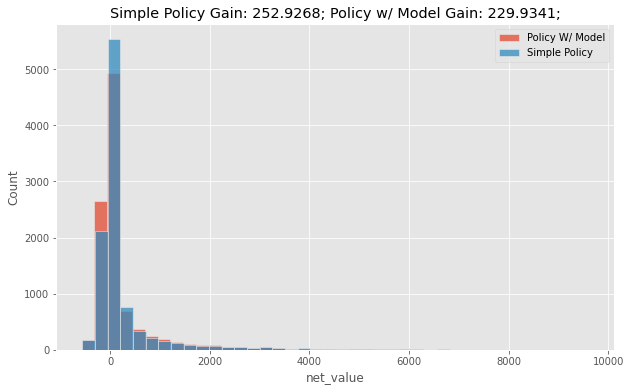

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");

Aqui é onde a maioria dos Cientistas de Dados ficam perplexos. A política com o modelo tem uma média de `net_income` que é 20 BRL pior do que uma política muito simples. Como um modelo que é bom em prever `net_value` não pode ser bom para uma estratégia que visa maximizar `net_value`? Certamente, deve haver algum bug no código. Você está claramente enganado. Isso não pode ser! Bem, acontece que há uma explicação perfeitamente razoável e simples para isso. No entanto, a resposta a esta pergunta é tão importante que acho que vale a pena aprofundar um pouco mais.

## Martelando o Polegar com Previsões

A resposta curta reside em entender o que queremos com esta política, ou seja, otimizar `net_value` brincando com os valores dos cupons. Se fosse para colocar isso em uma imagem, não seria loucura pensar que `net_value` terá uma forma quadrática em relação aos cupons: à medida que aumentamos o valor do cupom, `net_value` primeiro aumenta, depois atinge um ponto máximo. Depois disso, qualquer valor adicional do cupom custará mais do que o valor que ele traz.

![img](./data/img/when-prediction-fails/opt-deriv.png)

Encontrar o valor ideal do cupom é equivalente a encontrar o máximo da função `net_value`. Podemos fazer isso diferenciando a função e igualando a zero (segundo gráfico). Economistas podem reconhecer isso como um problema de precificação. A maneira como eles (nós) abordariam esse problema seria assumir uma forma funcional para `net_value`, diferenciá-la e otimizá-la.

Há alguns grandes méritos nesta abordagem, mas sinto que ela não é tão geral e requer uma grande dose de hipóteses. Infelizmente, os dados do mundo real não vêm com uma função subjacente que podemos diferenciar, então frequentemente envolve algum tipo de tentativa e erro. Uma abordagem mais prática (e talvez menos elegante) é testar múltiplos valores de cupom e ver qual deles gera o melhor `net_value`. Isso é exatamente o que nossa política simples faz. Ela observa o que aconteceu no passado e repete o tratamento que mostrou ser o mais promissor.

Contraste isso com o que a política baseada em modelo faz. Primeiro, a política baseada em modelo ajusta um modelo de aprendizado de máquina para prever `net_value`. Em seguida, ela divide o espaço do cliente de acordo com as previsões. Se o modelo for bom, isso é aproximadamente igual a dividir o espaço por `net_value` em si, assim como no gráfico a seguir.

![img](./data/img/when-prediction-fails/model-opt.png)

Quanto melhor a previsão, mais essa divisão do espaço se aproxima da divisão da variável-alvo, `net_income`. Preste muita atenção ao que acontece quando você faz isso. Essencialmente, você está dividindo o cliente em conjuntos onde `net_value`, a coisa que você previu, não muda! E isso faz total sentido do ponto de vista preditivo. Se seu modelo é bom em prever, grupos de pontos que têm a mesma previsão também terão o mesmo `net_value`.

Até agora, tudo bem, mas veja o que isso faz para a função percebida de `net_value` sobre os cupons (linhas verdes). Ela as achata para não ter inclinação alguma. Do ponto de vista preditivo, isso é incrível. Significa que seu modelo capturou toda a variação em `net_income`. No entanto, do ponto de vista da política, isso é terrível, porque não há mais variação em `net_income` para que possamos ver como ela mudaria com diferentes valores de cupom. Sem essa variação em `net_income`, pareceria que a alteração dos valores do cupom não tem efeito algum sobre `net_income`, não nos deixando espaço para otimização. A propósito, isso é um fenômeno geral que não tem nada a ver com a forma quadrática específica que estamos usando aqui. Estou apenas usando um exemplo para tornar as coisas mais concretas.

![img](./data/img/when-prediction-fails/flat-curves.png)

Para resumir, sempre que quisermos otimizar alguma variável $Y$ usando alguma variável $T$, prever $Y$ não apenas não ajudará, mas prejudicará nossa política, pois as partições de dados definidas pela previsão terão variação limitada de $Y$, dificultando nossa capacidade de estimar como $T$ muda $Y$, ou seja, a elasticidade $\frac{\delta Y}{\delta T}$. Este é o parágrafo mais importante deste capítulo. Tudo está resumido aqui, então releia se não entendeu de primeira.

A chave para corrigir esse erro está em ajustar nosso objetivo para o que realmente queremos. Em vez de estimar $Y$ a partir de $X$, que é o que a previsão faz, precisamos estimar $\frac{\delta Y}{\delta T}$ a partir de $X$. Mais fácil falar do que fazer. Como você já deve ter percebido, isso é precisamente o que inferência causal trata. E, como é natural em problemas causais, não podemos observar nossa quantidade de interesse $\frac{\delta Y}{\delta T}$. Simplesmente não podemos observar como `net_income` mudaria se mudássemos o valor do cupom porque só observamos uma instância de cupom por cliente. Nunca poderemos saber o que teria acontecido se um valor de cupom diferente tivesse ocorrido (a menos que usemos dados simulados, é claro. Mas isso é útil apenas para fins de ensino).

Essa característica dos problemas causais leva a outras perguntas: como posso saber se meu modelo é bom se não posso ver o que ele está supostamente estimando? Como posso validar um modelo assim? Além disso, o que fazemos quando os dados não são aleatórios? Como podemos estimar a melhor política sob dados enviesados? São perguntas válidas e as responderemos com o tempo. Enquanto isso, tenha em mente que, à medida que mudamos nosso foco de estimar $Y$ para estimar $\frac{\delta Y}{\delta T}$, muitas coisas terão que mudar de acordo. O conjunto de ferramentas tradicional de aprendizado de máquina precisará de algumas adaptações.


## Quando a Previsão Pode Ajudar

Toda essa confusão com aprendizado de máquina atrapalhando nossa capacidade de inferir efeitos causais vem de confundir o verdadeiro objetivo. Vem de estimar $Y$ em vez de $\frac{\delta Y}{\delta T}$. Mas às vezes, você pode realmente conseguir usar um modelo de previsão para atingir um objetivo de inferência causal. Mas para que isso aconteça, $Y$ e $\frac{\delta Y}{\delta T}$ devem estar de alguma forma correlacionados. Por exemplo, considere os casos na imagem abaixo.


![img](./data/img/when-prediction-fails/waiting-time.png)

O primeiro é o problema que vimos antes de entender como os cupons impactam a lucratividade. Primeiro, à medida que aumentamos o valor do cupom, a lucratividade aumenta. Se eles aumentam juntos, podemos ver que estão positivamente correlacionados. Além disso, no gráfico da derivada, no início, à medida que aumentamos o valor do cupom, a elasticidade $\frac{\delta Y}{\delta T}$ diminui. Se colocarmos ambos juntos, na primeira região do gráfico, à medida que o valor líquido aumenta, a elasticidade diminuirá. Isso significa que eles são negativamente correlacionados.

Mas isso é apenas no início. Se continuarmos aumentando o valor do cupom, a lucratividade diminuirá e a elasticidade da lucratividade também diminuirá. Isso significa que $\frac{\delta Y}{\delta T}$ e $Y$ estão agora positivamente correlacionados. Portanto, enquanto o resultado e a elasticidade são negativamente correlacionados no início, essa correlação se inverte à medida que aumentamos os valores dos cupons. Isso significa que um modelo de previsão não nos ajudará aqui porque não há uma relação direta entre o resultado e a elasticidade do resultado.

Outra forma de pensar sobre isso é que os modelos de previsão fazem cortes nos dados no eixo $Y$. Se fizermos esse tipo de cortes, misturaremos unidades que estão tanto na região de elasticidade positiva quanto na região de elasticidade negativa.

![img](./data/img/when-prediction-fails/slice-1.png)

Agora, considere um segundo caso em que queremos ver como esperar na fila para ser atendido pelo serviço ao cliente impacta a satisfação do cliente. Neste caso, podemos ver que a satisfação do cliente diminui bastante rapidamente nos primeiros minutos de tempo de espera. Os clientes ficam realmente irritados quando passam de não ter que esperar muito para ter que esperar um pouco. No entanto, à medida que o tempo de espera aumenta, a satisfação do cliente já está tão baixa que não cai muito depois. Isso meio que se estabiliza em um nível mais baixo.

Este caso é interessante porque a relação entre $\frac{\delta Y}{\delta T}$ e $Y$ não muda muito. Sempre está negativamente correlacionada. À medida que o tempo de espera aumenta, a satisfação diminui e a elasticidade da satisfação aumenta. Ou, à medida que $T$ aumenta, $\frac{\delta Y}{\delta T}$ também aumenta e $Y$ diminui. Neste caso, um modelo de previsão pode ser útil. A razão para isso é que, agora, se fizermos cortes no eixo $Y$, agruparemos unidades que têm elasticidades semelhantes.

![img](./data/img/when-prediction-fails/slice-2.png)

De maneira mais geral, sempre que temos esses tipos de formas funcionais em que a elasticidade muda mais ou menos na mesma direção que o resultado, você pode se safar com modelos de previsão. Agora, tenha cuidado aqui. Isso não significa que eles são sua melhor opção nem que você deve usá-los para problemas causais. Estou simplesmente afirmando isso para que, quando você se deparar com um modelo de previsão que funcione para um objetivo causal, você possa entender o que está acontecendo.

# Uma Explicação Gráfica

O fato de que os modelos de previsão podem ser prejudiciais para a personalização é tão contra-intuitivo e estranho que sinto que devo abordar o problema de múltiplas perspectivas. A seguinte explicação gráfica é, portanto, uma maneira de entender o que está acontecendo de um ângulo diferente.

Considere o gráfico causal mais à esquerda na imagem abaixo. É um gráfico típico de confusão, onde temos características $X$ causando tanto o resultado $Y$ quanto o tratamento $T$. O que acontece se você construir um modelo preditivo e usá-lo para segmentar as unidades por suas previsões?

![img](./data/img/when-prediction-fails/graph-1.png)

Você acaba obtendo algo semelhante aos gráficos à esquerda (tecnicamente, eles não são mais causais, porque o modelo obviamente não causa o resultado. Ele apenas aprende a função de mapeamento das características para os resultados, mas isso não invalida os pontos que estou prestes a fazer). Segmentar neste modelo é equivalente a condicionar o nó do modelo. Você está mantendo $M(T, X)$ fixo em cada segmento. Se você fizer isso e tentar aprender a relação entre $T$ e $Y$ enquanto condiciona $M(T, X)$, você acabará com a situação que discutimos na parte I, sobre controles ruins. E no caso de você não se lembrar, se você controlar qualquer coisa no caminho entre o tratamento e o resultado, você bloqueará um caminho que o tratamento está usando para afetar o resultado. Como consequência, o efeito percebido acaba parecendo menor do que o efeito real. Então, é isso. Usamos outra explicação para chegar à exata mesma conclusão de antes: segmentar unidades por um modelo preditivo prejudica nossa capacidade de identificar o efeito causal.

Agora, se você for esperto, provavelmente irá questionar com a seguinte ideia. E se simplesmente removermos $T$ do modelo? Esse é um argumento realmente bom. Na verdade, é tão bom que levei anos para articular adequadamente por que tentar enganar seu modelo dessa forma provavelmente não é uma coisa inteligente a se fazer. Na verdade, se você voltar ao exemplo que exploramos neste capítulo, observe que nem mesmo dei ao modelo preditivo o tratamento `coupon`. Isso não resolveu o problema de que a segmentação do modelo preditivo estava achatando nossa elasticidade medida para uma linha horizontal. A resposta para o motivo está na imagem a seguir.

![img](./data/img/when-prediction-fails/graph-2.png)

Excluir o tratamento $T$ do seu modelo $M(X)$ não é suficiente para fazer com que o modelo ignore o relacionamento entre $T$ e $Y$. Porque $X$ causa $T$, o modelo pode aprender indiretamente $T$ por meio de $X$. Por que ele faria isso? Porque se $T$ causa $Y$ e $M$ quer prever $Y$ o máximo possível, ele explorará forçosamente o padrão em $X$ que liga $T$ a $Y$. Em outras palavras, a informação de como o tratamento afeta os resultados flui para trás em nosso modelo por meio das características. Para dar um exemplo, suponha que você dê descontos ($T$) apenas aos clientes que moram em uma determinada área da cidade ($X$). Para argumentar, suponha que a área não causa vendas ($Y$) de forma alguma. Mesmo que seja o caso, a área da cidade ainda tem poder preditivo porque causa $T$, que por sua vez causa $Y$. Portanto, o modelo explorará esse fato para prever $Y$. 

Para ser justo com esse argumento, você realmente pode enganar seu modelo um pouco não dando $T$ a ele. Para ver isso, recomendo que você execute novamente o código em nossos exemplos, mas desta vez inclua `coupons` na lista de características para o modelo preditivo. Você verá que o Modelo de Política se sairá ainda pior. Isso significa que NÃO fornecer $T$ ao nosso modelo está fazendo algum bem, embora não muito.

Finalmente, há uma maneira de contornar isso, que é quando $T$ é aleatório. Nesse caso muito específico, um modelo preditivo pode realmente ajudar na inferência causal. Mas primeiro, vamos entender por que ele não prejudica. Quando $T$ é aleatório, isso exclui qualquer confusão que venha de $X$. Nesse caso, $X$ não tem informações sobre como $T$ surge.

![img](./data/img/when-prediction-fails/graph-3.png)

Quando isso acontece, mesmo se você controlar $M(X)$, ainda está permitindo que todo o efeito de $T$ flua para $Y$. Em outras palavras, mesmo se você olhar dentro de segmentos onde $M(X)$ é fixo, $Y$ ainda variará devido a $T$. $M(X)$ não pode mais controlar essa variabilidade porque não tem mais como aprender $T$. Além disso, esse tipo de condição ajudará você a descobrir o Efeito Médio do Tratamento. Também vimos isso na Parte I. Se controlarmos variáveis que são boas preditoras de $Y$, mas que não causam $T$, reduziremos a variância de nossas estimativas causais. A razão intuitiva é que muita da variação em $Y$ devido a $X$ é removida condicionando o modelo. Uma vez que $X$ é explicado, a razão pela qual $Y$ ainda está mudando deve ser principalmente devido a $T$ (ou outras coisas não medidas, mas você entende que isso ajuda).

Mais uma vez, isso não é um argumento a favor do uso de modelos preditivos quando o objetivo é inferência causal. Na verdade, os segmentos definidos por um modelo preditivo ajudarão você a identificar o ATE, mas isso não significa que cada partição terá um ATE (ou elasticidade) diferente. Lembre-se de que você não só quer estimar a elasticidade, mas também deseja encontrar segmentos onde ela seja maior ou menor que a média, para que você possa personalizar o tratamento.

## Conceitos-chave 

Vimos como há uma ampla gama de problemas que não são solucionáveis com a tradicional Aprendizagem de Máquina preditiva. Esses problemas são de otimização, com um componente causal, geralmente formulados como "como devo configurar essa variável que posso controlar, T (preço, número de chamadas telefônicas, desconto, ...), a fim de otimizar essa métrica, Y (lucros, satisfação do cliente, conversão, custos...)". Quando esse é o caso, modelos preditivos podem fazer mais mal do que bem.

Para comprovar esse ponto, passamos por um exemplo em que precisávamos encontrar o melhor valor de cupom. A primeira abordagem foi analisar dados passados para identificar qual valor de cupom resultou na maior receita. Em seguida, pegamos esse valor supostamente ótimo e o atribuímos a todos os clientes. Essa abordagem responde à pergunta sobre qual é o melhor valor de cupom (tratamento, em termos causais), em média. Ou seja, se tivéssemos que escolher apenas um valor fixo de cupom, qual deveria ser. Mas não temos tal restrição. Se acontecer de alguns clientes responderem melhor a cupons de valor mais baixo e outros responderem melhor a cupons de valor mais alto, poderíamos personalizar o cupom para cada cliente. Para fazer isso, tentamos construir um modelo preditivo de Aprendizado de Máquina que previa o valor que cada cliente traria. Em seguida, tentamos personalizar o valor do cupom com base nas previsões do modelo. Agrupamos os clientes de acordo com as previsões e, para cada grupo, encontramos qual valor de cupom era o melhor. Depois, tentamos usar esse valor aprendido como uma estratégia de cupom. No entanto, descobrimos que ele se saiu pior do que a estratégia simples de dar o mesmo valor de cupom para todos. Em outras palavras, nosso modelo de ML falhou em separar os clientes que responderam melhor ou pior ao valor do cupom.

Observe que o problema que estamos tentando resolver aqui é de **personalização**. Em nosso caso, era tentar descobrir qual valor de cupom é o melhor para cada cliente. De maneira mais geral, é formulado como "qual é a melhor decisão $T$ que posso tomar para cada cliente $i$ de forma a maximizar $Y_i$ entre todos os clientes". Este não é um problema fácil de resolver, mas podemos resolvê-lo com a ajuda da inferência causal.

Há uma coisa importante que quero que você tire deste capítulo. Primeiro, observe que a inferência causal, como vimos na parte um, ajuda você a projetar políticas como a simples que construímos. Com elas, estamos tentando estimar o efeito causal médio para o tratamento e encontrar o tratamento que funciona melhor em média. Agora, estamos ficando mais ambiciosos. Não queremos o melhor tratamento em média, queremos o melhor tratamento para cada cliente individual. É disso que se trata a personalização e ela depende muito dos métodos de inferência causal.

## Referências

As coisas que escrevi aqui são em sua maioria ideias que surgiram em minha mente. Aprendi essas coisas por meio da experiência. Isso significa que não há uma referência direta que eu possa indicar. Também significa que as coisas que escrevi aqui **não** passaram pela escrutínio acadêmico que a boa ciência frequentemente enfrenta. Em vez disso, observe como estou falando sobre coisas que funcionam na prática, mas não dedico muito tempo a explicar por que isso é assim. É uma espécie de ciência das ruas, por assim dizer. No entanto, estou submetendo isso à escrutínio público, então, de alguma forma, se encontrar algo absurdo, abra uma issue, e eu o abordarei da melhor forma possível. 

Para este capítulo, não há muitos pontos específicos para indicar. Há apenas um ótimo artigo que formula o problema de personalização que estamos tentando resolver com inferência causal: *Recursive Partitioning for Heterogeneous Causal Effects, Susan Athey and Guido Imbens, 2016*. Além disso, a primeira imagem é de um vídeo do YouTube de Siraj Raval.

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<div align="center">
<a href="Debiasing-with-Propensity-Score.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="Prediction-Metrics-For-Causal-Models.ipynb">Próximo --></a>  

<a href="https://matheusfacure.github.io/python-causality-handbook/When-Prediction-Fails.html">[When Prediction Fails]</a>  

</div>